# <center> News Classification with NLP and Neural Networks</center>

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn import preprocessing
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

### Data
- Import JSON file
- Limit to top categories

In [2]:
# Read in json file to DataFrame
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

# View Results
print(df.shape)
df.sample(5)

(200853, 6)


,category,headline,authors,link,short_description,date
136167,STYLE & BEAUTY,Jenna Talackova Scores Fashion Spread In Elle ...,Ellie Krupnick,https://www.huffingtonpost.com/entry/jenna-tal...,Want more? Be sure to check out HuffPost Style...,2013-12-18
161520,WELLNESS,Tabura: A Dance Workout With An Ethnic Twist A...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/dance-wor...,"""And you can make friends. Research findings s...",2013-03-25
140232,PARENTING,Baby In An LED Costume Is Even More Enchanting...,,https://www.huffingtonpost.com/entry/led-costu...,The LED stick figure costume that took the Int...,2013-11-05
174496,STYLE & BEAUTY,Rope Braids: A Braided Hairstyle Even Amateurs...,Dana Oliver,https://www.huffingtonpost.com/entry/rope-brai...,All it takes is just two simple twists.,2012-11-07
195529,HOME & LIVING,12 Ways To Decorate With Colorful Flowers This...,Dickson Wong,https://www.huffingtonpost.com/entry/decoratin...,"Now that spring is here, we're looking at ways...",2012-03-25


# Cleaning

#### Check data types

#### Check NaNs 

#### Check Duplicates

In [3]:
print(f"There are {df.duplicated().sum()} duplicated rows")

# Drop duplicates
df = df.drop_duplicates()

print(f"There are now {df.duplicated().sum()} duplicated rows")

There are 13 duplicated rows
There are now 0 duplicated rows


### Dates

In [4]:
df['date'] = df['date'].dt.year

#### Authors 
- The `authors` field is a list containing:
    - Name(s)
    - Titles
    - Organizations
    - Misc comments
- It also contains many NaNs in the form of empty strings
- Approach:
    - Replace NaNs with 'unknown'
    - Extract author names from the field, create new field named `author_names` to be used as a bigram
    - Leave the rest of the information in a new field named `author_notes`

### Author Names
- Replace missing
- Get Names
- Clean non-name details
- Cast as strings

In [5]:
# Replace missing authors with 'unknown'
df['authors'] = df['authors'].apply(lambda x: x.replace('','unknown') if x == '' else x)

In [6]:
# Get author names from list
df['author_names'] = df['authors'].apply(lambda x: x.replace('By','').strip().split(',')[0].lower().split(' And '))

In [7]:
# Clean up common formatting issues
df['authors'] = df['authors'].apply(lambda x: x.replace('By','').replace('\n','').replace('Contributor','Contributor ').strip())

### Links
- The links are not helpful in their current form, need to extract keyworks from them

In [8]:
# Replace charaters we want to split on with commas, then split, only get the relevant entries from the resulting list
df['link_keywords'] = df['link'].apply(lambda x: x.replace('-',',').replace("_",',').replace("entry/",',').split(',')[1:-2])

# Typecast from list to string
df['link_keywords'] = df['link_keywords'].apply(lambda x: ' '.join(x))

### Join all text columns

In [9]:
df['text'] = df['headline'] + ' ' + df['short_description'] + ' ' + df['link_keywords'] + ' ' + df['authors'] + ' ' + df['date'].astype(str)

### Drop unwanted features

In [10]:
# Drop the feature if it appear in the colums (done this way so the cell can be re-run)
df = df.drop(columns=[col for col in df.columns if col in ['link','authors','headline','short_description','date','link_keywords','author_notes','author_names']])

# View Sample
df.sample(5)

,category,text
160204,DIVORCE,Bad Breakup: Angry Girlfriend Keys Ex's Car Wi...
125417,SCIENCE,Researchers Take On Kermadec Trench Dive To Fi...
60490,CRIME,Female Firefighter's Suspected Suicide Sparks ...
121673,POLITICS,Begich Ad Mocks GOP Opponent's Embarrassing La...
130222,DIVORCE,"Saying ""I Do"" Over & Over What is it about mar..."


# <center> -------------------------------------------------------------------- </center>

# EDA

#### View categories

#### View length of texts

### Author Activity

# <center> -------------------------------------------------------------------- </center>

# Preprocessing Text Data
- Lower all words
- Handle misspellings?
- Stop words
- Stem / Lemmatize text
- Tokenization or specialized regex?
- Use all words or just most frequent?
- Use bigrams, POS taggins, Mutual information Scores?
- What sort of vectorization? (Boolean / Count / TF-IDF / Word2Vec)

In [11]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

### Encode Target Variable
- Assign a unique value to each categories

In [12]:
# Instantiate label encoder 
le = preprocessing.LabelEncoder()

# Label Encode categories
df['class_label'] = le.fit_transform(df['category'])

# Create dictionary to map labels to categories
label_to_category = dict(df.groupby('class_label')['category'].first())

### Get Stopwords

In [13]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

### Test Train Split

In [14]:
from sklearn.model_selection import train_test_split

# Define dependent and independent variables
X = df["text"]
y = df["class_label"]

# Perform Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8)

### Count Vectorization

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer with custom list of stop words
count_vectorizer = CountVectorizer(stop_words= stopwords_list)

# Fit the tokenizer on the training data
count_vectorizer.fit(X_train)

# Apply the tokenizer to the training and testing data
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
X_val_counts = count_vectorizer.transform(X_val)

# View Results
print(f'There are {X_train_counts.shape[0]} observations and {X_train_counts.shape[1]} features')

There are 128537 observations and 93540 features


## Model: Neural Network

In [16]:
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical

### OHE target

In [17]:
from keras.utils.np_utils import to_categorical

# OHE for netural network
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)

### Create model
- Fully connected (dense) layer network with relu activation
- 2 hidden layers with 50 units in 1st and 25 in second
- Softmax classifier for nulticlass problem

In [18]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(41, activation='softmax'))

### Compiling the model
- Loss function = categorical crossentropy
- Optimizer = stochastic gradient descent

In [19]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [20]:
# Train the model 
n_epochs = 10
history = model.fit(X_train_counts, y_train_ohe, epochs= n_epochs, validation_data = (X_val_counts, y_val_ohe))

Epoch 1/20
4017/4017 [==============================] - 6s 1ms/step - loss: 2.7935 - acc: 0.3041 - val_loss: 2.2104 - val_acc: 0.4452
Epoch 2/20
4017/4017 [==============================] - 5s 1ms/step - loss: 1.8466 - acc: 0.5279 - val_loss: 1.5911 - val_acc: 0.5857
Epoch 3/20
4017/4017 [==============================] - 5s 1ms/step - loss: 1.3836 - acc: 0.6354 - val_loss: 1.3021 - val_acc: 0.6481
Epoch 4/20
4017/4017 [==============================] - 5s 1ms/step - loss: 1.1161 - acc: 0.6993 - val_loss: 1.1461 - val_acc: 0.6852
Epoch 5/20
4017/4017 [==============================] - 5s 1ms/step - loss: 0.9376 - acc: 0.7452 - val_loss: 1.0549 - val_acc: 0.7083
Epoch 6/20
4017/4017 [==============================] - 5s 1ms/step - loss: 0.8082 - acc: 0.7782 - val_loss: 1.0031 - val_acc: 0.7215
Epoch 7/20
4017/4017 [==============================] - 5s 1ms/step - loss: 0.7078 - acc: 0.8033 - val_loss: 0.9712 - val_acc: 0.7313
Epoch 8/20
4017/4017 [==============================] - 5s 1ms

### Evaluation

In [49]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_model_metrics(actuals, predictions, full_report = False, plot = False):  

    predictions_bool = np.argmax(predictions, axis=1)
    
    precision = round(precision_score(actuals, predictions_bool, average='weighted'),3)
    recall = round(recall_score(actuals, predictions_bool, average='weighted'),3)
    f1 = round(f1_score(actuals, predictions_bool, average='weighted'),3)
    accuracy = round(accuracy_score(actuals, predictions_bool),3)
    
    if full_report == False:
        print(f"Accuracy = {accuracy} \nPrecision = {precision} \nRecall = {recall} \nf1 = {f1}")
    else:
        print(classification_report(actuals, predictions_bool))
    if plot == True:
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=[i for i in range(20)], y=history.history['acc'],
                            mode='lines+markers', name='Train Accuracy'))
        fig.add_trace(go.Scatter(x=[i for i in range(20)], y=history.history['val_acc'],
                            mode='lines+markers', name='Validation Accuracy'))

        fig.update_layout(height= 500, width= 700)

        fig.show()

Accuracy = 0.732 
Precision = 0.73 
Recall = 0.732 
f1 = 0.73


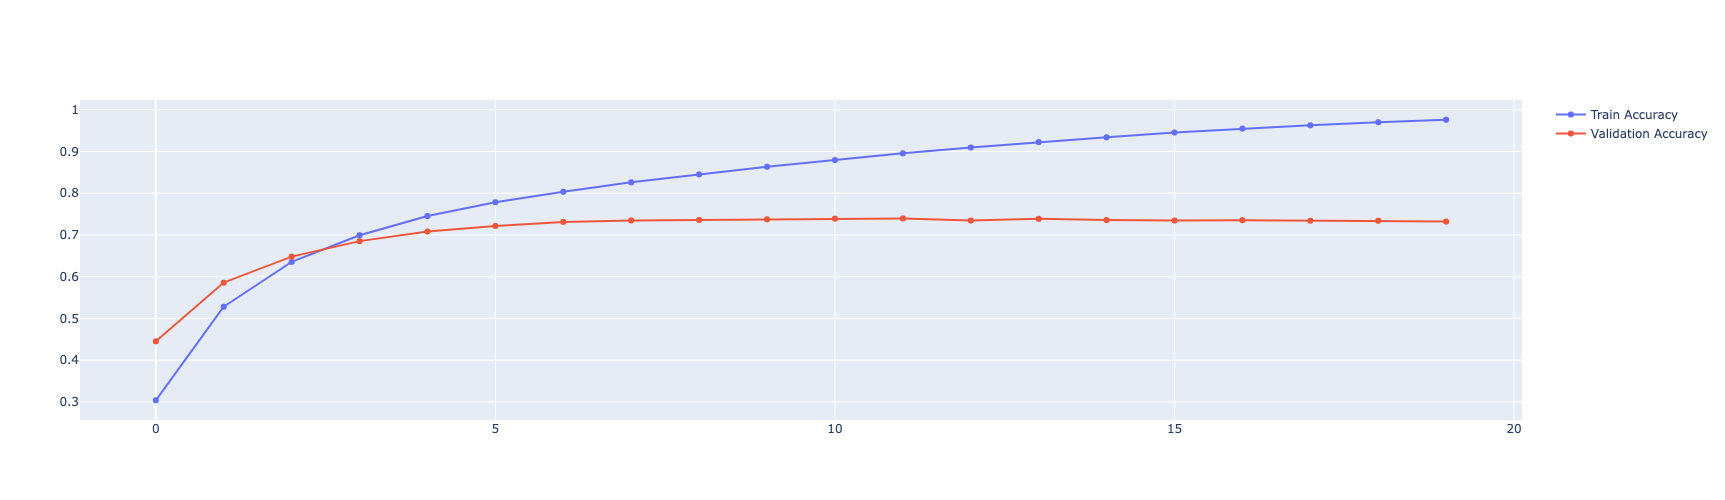

In [51]:
get_model_metrics(y_val, model.predict(X_val_counts), full_report = 0, plot = 1)